In [22]:
import tensorflow as tf
import seaborn as sns    
import re
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import lime.lime_tabular
import lime
import keras.preprocessing.text
import keras
import datetime 
import copy
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from random import *
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,SpatialDropout1D, MaxPooling1D
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras import backend as K
%matplotlib inline
plt.rc('font', family='NanumBarunGothicOTF')
mpl.rcParams['axes.unicode_minus'] = False

In [23]:
early_stopping = EarlyStopping(monitor='val_loss',patience=100,restore_best_weights=True)

### - 띄워쓰기 없는 부분 추가 : 1회만

In [3]:
# def inplace_change(filename, old_string, new_string):
#     with open(filename, 'r') as f:
#         print(f)
#         s = f.read()
#         s = re.sub(old_string, new_string, s)
        
#     with open(filename, 'w+') as f:
#         #print('Changing "{old_string}" to "{new_string}" in {filename}'.format(**locals()))
#         print(s)
#         f.write(s)    
        
# directory = "./위성/VIS/"
# f_list = os.listdir(directory)

# f_list.sort()
# temp = pd.DataFrame()

# for f in f_list:
#     #print(f)
#     inplace_change(directory + f,'[^\S\r\n]*-', ' -')

## 날짜 정보 추출

In [24]:
directory = "./위성/CDOM/"
f_list = os.listdir(directory)

date_list = []
for f in f_list:
    date_list.append(f[3:13])

In [5]:
date_list.sort()

## 수치모형 데이터 로드

In [25]:
directory = "./수치모형/temperature/"
vname = "temperature_"
temp_arr = []
for d in date_list:
    temp = pd.read_csv(directory + vname + str(d) +".csv",header=None,index_col=0)
    temp = temp.reset_index(drop=True)
    temp_arr.append(np.array(temp).tolist())  
    
directory = "./수치모형/salinity/"
vname = "salinity_"
salinity_arr = []
for d in date_list:
    salinity = pd.read_csv(directory + vname + str(d) +".csv",header=None,index_col=0)
    salinity = salinity.reset_index(drop=True)
    salinity_arr.append(np.array(salinity).tolist())  
    
directory = "./수치모형/velocity/"
vname = "velocity_"
velocity_arr = []
for d in date_list:
    velocity = pd.read_csv(directory + vname + str(d) +".csv",header=None,index_col=0)
    velocity = velocity.reset_index(drop=True)
    velocity_arr.append(np.array(velocity).tolist())  
    
directory = "./수치모형/waterlevel/"
vname = "waterlevel_"
waterlevel_arr = []
for d in date_list:
    waterlevel = pd.read_csv(directory + vname + str(d) +".csv",header=None,index_col=0)
    waterlevel = waterlevel.reset_index(drop=True)
    waterlevel_arr.append(np.array(waterlevel).tolist())  

## 위성 데이터 로드

In [26]:
directory = "./위성/CDOM/"
f_list = os.listdir(directory)

f_list.sort()
temp = pd.DataFrame()
cdom_result_arr = []

for idx,f in enumerate(f_list):
    #print(f)
    temp = pd.read_csv(directory + f, sep='\s+', header=None)
    cdom_result_arr.append(np.array(temp).tolist())   
    
directory = "./위성/CHLA/"
f_list = os.listdir(directory)

f_list.sort()
temp = pd.DataFrame()
chla_result_arr = []

for idx,f in enumerate(f_list):
    #print(f)
    temp = pd.read_csv(directory + f, sep='\s+', header=None)
    chla_result_arr.append(np.array(temp).tolist())   
    
    
directory = "./위성/TSS/"
f_list = os.listdir(directory)

f_list.sort()
temp = pd.DataFrame()
tss_result_arr = []

for idx,f in enumerate(f_list):
    #print(f)
    temp = pd.read_csv(directory + f, sep='\s+', header=None)
    tss_result_arr.append(np.array(temp).tolist())   
    
    
directory = "./위성/VIS/"
f_list = os.listdir(directory)

f_list.sort()
temp = pd.DataFrame()
vis_result_arr = []

for idx,f in enumerate(f_list):
    #print(f)
    temp = pd.read_csv(directory + f, sep='\s+', header=None)
    vis_result_arr.append(np.array(temp).tolist())   

## 데이터 배열형태로 변환

In [27]:
cdom_result_arr = np.array(cdom_result_arr)
chla_result_arr = np.array(chla_result_arr)
tss_result_arr = np.array(tss_result_arr)
vis_result_arr = np.array(vis_result_arr)
temp_arr = np.array(temp_arr)
salinity_arr = np.array(salinity_arr)
waterlevel_arr = np.array(waterlevel_arr)
velocity_arr = np.array(velocity_arr)

In [28]:
n = cdom_result_arr.shape[0]
w = cdom_result_arr.shape[1]
h = cdom_result_arr.shape[2]
c = 1

## 데이터 차원수 체크

In [29]:
print(cdom_result_arr.shape)
print(tss_result_arr.shape)
print(vis_result_arr.shape)

(1331, 48, 27)
(1331, 48, 27)
(1331, 48, 27)


## 데이터 결합

In [30]:
# Best 경우
cdom_result_arr= cdom_result_arr.reshape(n,w,h,c)
tss_result_arr= tss_result_arr.reshape(n,w,h,c)
vis_result_arr = vis_result_arr.reshape(n,w,h,c)
salinity_arr = salinity_arr.reshape(n,w,h,c)
waterlevel_arr = waterlevel_arr.reshape(n,w,h,c)
temp_arr = temp_arr.reshape(n,w,h,c)
velocity_arr = velocity_arr.reshape(n,w,h,c)

chla_result_arr= chla_result_arr.reshape(n,w,h,c)
print(cdom_result_arr.shape)

(1331, 48, 27, 1)


## 저장파일명 지정

In [31]:
fname = "II_ALL"

## 데이터 결합

In [20]:
# # 1개씩 쓸때
#x_all =  cdom_result_arr

In [23]:
# # Best 경우

# x_all = np.concatenate((tss_result_arr,salinity_arr),axis=3)
# x_all = np.concatenate((x_all, vis_result_arr),axis=3)

In [32]:
#전체
x_all = np.concatenate((cdom_result_arr, tss_result_arr),axis=3)
x_all = np.concatenate((x_all, vis_result_arr),axis=3)
x_all = np.concatenate((x_all, salinity_arr),axis=3)
x_all = np.concatenate((x_all, waterlevel_arr),axis=3)
x_all = np.concatenate((x_all, temp_arr),axis=3)
x_all = np.concatenate((x_all, velocity_arr),axis=3)

## 학습 및 테스트 데이터 분할

In [60]:
train_num = 932
val_num = 271

x_train = x_all[0:train_num]
x_val = x_all[train_num:train_num+val_num]
x_test = x_all[train_num+val_num:]

y_all = chla_result_arr
y_train = y_all[0:train_num]
y_val = y_all[train_num:train_num+val_num]
y_test = y_all[train_num+val_num:]

vidx = np.where(y_train[0].flatten() != 0)

In [35]:
w = x_all.shape[1]
h = x_all.shape[2]
d = x_all.shape[3]

In [21]:
# from keras import optimizers

# All parameter gradients will be clipped to
# a maximum norm of 1.
#sgd = optimizers.SGD(lr=0.003, clipnorm=1.)
# adam = optimizers.Adam(lr=0.001, clipnorm=0.001)

### 모형 학습

In [32]:
y_train2 = y_train.reshape(932,48*27*1)
y_val2 = y_val.reshape(271,48*27*1)

In [80]:
# Model2

leaky_relu = tf.nn.leaky_relu

import keras.backend.tensorflow_backend as K
with K.tf.device('/cpu:0'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation=leaky_relu,input_shape=(w,h,d)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation=leaky_relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation=leaky_relu))
    model.add(Dropout(0.5))
    model.add(Dense(w*h*1))
    model.compile(loss=RMSE, metrics=[RMSE],optimizer='adam')
    
with K.tf.device('/cpu:0'):
    hist = model.fit(x_train,y_train2, batch_size=256, epochs=50000,validation_data=[x_val,y_val2],callbacks=[early_stopping])

## 히스토리 저장

In [ ]:
hist_df = pd.DataFrame(hist.history).sort_values(['val_loss'])
hist_df.to_excel(fname + ".xlsx")

## 모델 저장

In [ ]:
model.save(fname + ".h5")

## 모델 로드

In [49]:
from keras.models import load_model
import keras.backend.tensorflow_backend as K

with K.tf.device('/cpu:0'):
    model = load_model(fname+".h5",custom_objects={'leaky_relu': tf.nn.leaky_relu,'RMSE': RMSE})

In [68]:
# import matplotlib.pyplot as plt

# fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

# loss_ax.plot(hist.history['loss'][1:], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'][1:], 'r', label='val loss')
# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# loss_ax.legend(loc='upper left')

# plt.show()

In [53]:
x_test.shape

(128, 48, 27, 7)

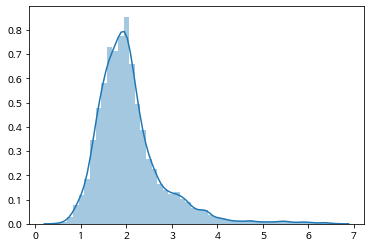

In [61]:
x_test2 = x_test
y_test2 = y_test
sns.distplot(y_test2[y_test2 !=0])

In [62]:
len(y_test2[y_test2 !=0])

45056

In [63]:
np.std(y_test2[y_test2 !=0])

0.7456494691892561

In [56]:
from sklearn.metrics import mean_squared_error

In [73]:
rmse_list = []
for n in range(0,128):
    x_test = x_test2[n:(n+1)]
    y_test = y_test2[n:(n+1)]

    x_test_list = []
    y_test_list = []     

    pred = model.predict(x_test)

    y_test_re = y_test.reshape(1,w*h)
    sub_pred = pred[y_test_re !=0]
    sub_y_test = y_test_re[y_test_re !=0]

    rmse = mean_squared_error(sub_y_test, sub_pred)**0.5

    rmse_list.append(rmse)

print(np.mean(rmse_list))
rmse_df = pd.DataFrame(rmse_list)
rmse_df.to_excel(fname+"_RMSE.xlsx")

0.43583831333008805


/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '0.9.8' or newer of 'xlsxwriter' (version '0.7.3' currently installed).
  warnings.warn(msg, UserWarning)


In [75]:
rmse_list

[0.31957646663079986,
 0.486606847418984,
 0.4904737761320719,
 0.4985429872270059,
 0.2581985029940953,
 0.3343194846375271,
 0.26063137081265575,
 0.27417981898352334,
 0.42116911314087907,
 0.36726195166509773,
 0.47949446639360144,
 0.6322138198956535,
 0.23435039595054397,
 0.26835852275115596,
 0.21797906120825797,
 0.3151980886026424,
 0.40250020043233614,
 0.5956095610247149,
 0.25097497091546733,
 0.2196500047634812,
 0.19405707867989747,
 0.23087972979229093,
 0.17803705441675857,
 0.19033515288921643,
 0.19977152935235948,
 0.5111358943631357,
 1.0498782280799004,
 0.46471252718165185,
 0.20815756734104932,
 0.19562607878042565,
 0.4216285345466442,
 0.29723972556216754,
 0.23095016765118664,
 0.10597278636952018,
 0.5401866182064694,
 0.40752510131957875,
 0.2782291939657292,
 0.6082216263198551,
 0.6084894121131401,
 0.2811861398343114,
 0.23989356552072424,
 0.26656749355448633,
 0.3331445638357468,
 0.179394004626258,
 0.3434499332045948,
 0.4287129689543941,
 0.75197583

### 한 데이터씩 살피기

In [238]:
n = 102
x_test = x_test2[n:(n+1)]
y_test = y_test2[n:(n+1)]

x_test_list = []
y_test_list = []     
            
from sklearn.metrics import mean_squared_error
pred = model.predict(x_test)

y_test_re = y_test.reshape(1,w*h)
sub_pred = pred[y_test_re !=0]
sub_y_test = y_test_re[y_test_re !=0]

rmse = mean_squared_error(sub_y_test, sub_pred)**0.5

y_test = y_test_re.reshape(w,h)
pred[y_test_re == 0] = 0
pred = pred.reshape(w,h)

In [239]:
max_val = max(y_test_re.flatten())

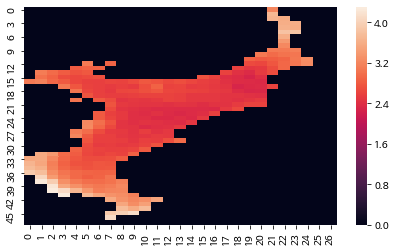

In [240]:
sns.heatmap(pred,vmax=max_val)

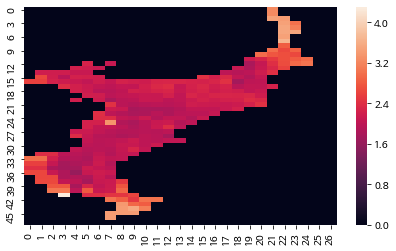

In [241]:
sns.heatmap(y_test,vmin=0,vmax=max_val)

In [ ]:
sns.distplot(y_test_re.flatten())

In [ ]:
sns.distplot(result_re.flatten())

In [242]:
y_true = y_test_re.flatten()
y_pred = pred.flatten()

y_true = y_true[y_pred != 0]
y_pred = y_pred[y_pred != 0]


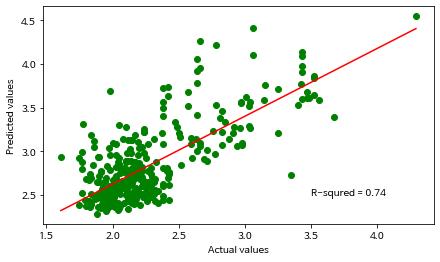

In [244]:
import scipy as sp
linreg = sp.stats.linregress(y_true, y_pred)
r2 = linreg.rvalue

plt.scatter(y_true,y_pred,color="green")
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_pred, 1))(np.unique(y_true)),color="red")
plt.rcParams["figure.figsize"] = (7, 4)
plt.text(3.5,2.5,'R-squred = %0.2f' % r2)
plt.show()

In [182]:
r2_list = []
for n in range(0,128):
    x_test = x_test2[n:(n+1)]
    y_test = y_test2[n:(n+1)]

    x_test_list = []
    y_test_list = []     

    from sklearn.metrics import mean_squared_error
    pred = model.predict(x_test)

    y_test_re = y_test.reshape(1,w*h)
    sub_pred = pred[y_test_re !=0]
    sub_y_test = y_test_re[y_test_re !=0]

    rmse = mean_squared_error(sub_y_test, sub_pred)**0.5

    y_test = y_test_re.reshape(w,h)
    pred[y_test_re == 0] = 0
    pred = pred.reshape(w,h)
    
    y_true = y_test_re.flatten()
    y_pred = pred.flatten()

    y_true = y_true[y_pred != 0]
    y_pred = y_pred[y_pred != 0]
    import scipy as sp
    linreg = sp.stats.linregress(y_true, y_pred)
    r2 = linreg.rvalue
    r2_list.append(r2)


In [185]:
r2_df = pd.DataFrame(r2_list)

In [186]:
r2_df.to_excel("./result/r2_df.xlsx")

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '0.9.8' or newer of 'xlsxwriter' (version '0.7.3' currently installed).
  warnings.warn(msg, UserWarning)
